# Lab 10-3: YOLO for Object Detection
## Exercise: Implement YOLO v1 Loss Function

Verifying a loss function for object detection requires special ground truth and prediction result,
otherwise the loss value could be meaningless.

In [59]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

n_batch = 2

o_locatn = np.zeros((n_batch,7,7))

y_tr = np.zeros(shape=(n_batch,7,7,30), dtype=float)
y_tm = np.zeros(shape=(n_batch,7,7,30), dtype=float)

np.random.seed(6)

for n in range(n_batch):

    obj_bbox = np.random.rand(8,4)
    prd_bbox = np.clip(obj_bbox + (np.random.randn(8,4) * 0.05), a_min=0.0, a_max=1.0-1e-8)
    n_object = np.random.randint(low=4, high=8)
    
    for i in range(n_object):
        tbox = np.zeros((4))
        tbox[0:2] = np.minimum(obj_bbox[i,0:2], obj_bbox[i,2:4]) # y,x of bottom left
        tbox[2:4] = np.maximum(obj_bbox[i,0:2], obj_bbox[i,2:4]) # y,x of top right
        c_y, c_x = (tbox[0:2] + tbox[2:4]) / 2   # y,x of center
        c_h, c_w = tbox[2:4] - tbox[0:2]         # h,w of bbox
        i_y, i_x = int(c_y*7), int(c_x*7)
        c_y, c_x = c_y*7 - i_y, c_x*7 - i_x
        # for yolov2: tbx1 & tbx2 represent different anchors
        tbx1 = np.array([1.0, c_y, c_x, c_h, c_w])  # true box coordinate
        tbx2 = np.array([0.0, c_y, c_x, c_h, c_w])  # set confidence 0; null box
        clss = np.zeros((20))
        clss[np.random.randint(20)] = 1.0
        y_tr[n, i_y, i_x] = np.concatenate((tbx1, tbx2, clss), axis=0)

        o_locatn[n, i_y, i_x] = 1.0  # not in true tensor, just display purpose
    
        pbox = np.zeros((4))
        pbox[0:2] = np.minimum(prd_bbox[i,0:2], prd_bbox[i,2:4]) # y,x of bottom left
        pbox[2:4] = np.maximum(prd_bbox[i,0:2], prd_bbox[i,2:4]) # y,x of top right
        c_y, c_x = (pbox[0:2] + pbox[2:4]) / 2 # y,x of center
        c_h, c_w = pbox[2:4] - pbox[0:2]       # h,w of bbox
        i_y, i_x = int(c_y*7), int(c_x*7)
        c_y, c_x = c_y*7 - i_y, c_x*7 - i_x
        # for yolov2: pbx1 & pbx2 represent different anchors
        cnf1 = 0.3 if np.random.random()>0.5 else 0.7
        cnf2 = 1.0 - cnf1
        pbx1 = np.array([cnf1, c_y, c_x, c_h, c_w])
        pbx2 = np.array([cnf2, c_y, c_x, c_h, c_w])
        y_tm[n, i_y, i_x] = np.concatenate((pbx1, pbx2, clss), axis=0)
    
    y_pr = y_tm + np.random.randn(7,7,30) * 0.01

y_true = tf.cast(y_tr, dtype=tf.float32)
y_pred = tf.cast(y_pr, dtype=tf.float32)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


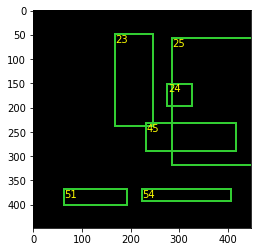

In [60]:
print(o_locatn[0])

sample = np.zeros((448,448,3))
img_h, img_w, _ = sample.shape
plt.imshow(sample)
axs = plt.gca()   # get current axes

for j in range(7):
    for i in range(7):
        if y_true[0,j,i,0]==1:
            c_y, c_x, c_h, c_w = y_true[0,j,i,1:5]
            c_y, c_x = (c_y + j)/7, (c_y + i)/7
            obj_y, obj_x, obj_h, obj_w = (c_y-c_h/2)*img_h, (c_x-c_w/2)*img_w, c_h*img_h, c_w*img_w
            bbox = patches.Rectangle((obj_x,obj_y), obj_w, obj_h, 0, linewidth=2, edgecolor='limegreen', fill = False)
            axs.add_patch(bbox)
            plt.text(obj_x+1, obj_y+17, str(j)+str(i), color='yellow')

plt.show()

### Loss Function for YOLO v1

$$ \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \bold{1}_{ij}^{obj} \left[ (x_i - \hat{x}_i)^2+(y_i - \hat{y}_i)^2 \right] 
+\lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \bold{1}_{ij}^{obj} \left[ \left( \sqrt{w_i} - \sqrt{\hat{w}_i} \right)^2 
+ \left(\sqrt{h_i} - \sqrt{\hat{h}_i} \right)^2 \right] $$
$$ + \sum_{i=0}^{S^2} \sum_{j=0}^{B} \bold{1}_{ij}^{obj} \left( c_i - \hat{c}_i \right)^2 
+\lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \bold{1}_{ij}^{noobj} \left( c_i - \hat{c}_i \right)^2 $$
$$ + \sum_{i=0}^{S^2} \bold{1}_{ij}^{obj} \sum_{c \in classes} \left( p_i(c) - \hat{p}_i (c) \right)^2 $$

**Note:** The original YOLO v1 evaluates object confidence and object class with MSE even though they are probabilities.<br>
In this implementation you can use sigmoid and softmax to make the convergence of the model more stable.

In [69]:
def yolo_loss_fn(y_true, y_pred):
    
    l_coord = 5.0  # lambda_coord
    l_noobj = 0.5  # lambda_noobj
    n_grid = 7
    n_batch = tf.shape(y_true)[0]

    # make a matrix of grid index
    idx_no0 = tf.reshape(tf.range(0, n_grid, dtype=tf.float32), [1,n_grid,1,1,1]) # (1,g,1,1,1)
    idx_no1 = tf.repeat(idx_no0, repeats=n_grid, axis=2) # (1,g,g,1,1)
    idx_no2 = tf.transpose(idx_no1, [0,2,1,3,4])         # (1,g,g,1,1)
    idx_ar0 = tf.concat([idx_no1,idx_no2], axis=-1)      # (1,g,g,1,2)
    # make two matrices of grid index
    idx_arr = tf.repeat(idx_ar0, repeats=2, axis=-2)     # (1,g,g,2,2)

    # (1) yolo_head for y_true: box_confidence, box_yx, box_hw, box_class_probs
    # for yolov1, only 1 true object per grid is used
    # Since there are two sets of box proposals, duplicate ground truth for easy comparison
    y_true_1c = tf.expand_dims(y_true, axis=-2)          # make a room (new axis) at -2 to repeat
    y_true_2c = tf.repeat(y_true_1c, repeats=2, axis=-2) # make two copies of truth for easy computation

    ### START CODE HERE ###
    
    # copy true_box_yx (offset) and apply grid location
    true_o_yx = y_true_2c[..., 1:3]                # get (y,x) offset from y_true_2c
    true_c_yx = (true_o_yx + idx_arr) /  tf.cast(tf.reshape(tf.constant([n_grid, n_grid]), [1, 1, 1, 1, 2]), dtype=y_true_2c.dtype)               # apply grid position and normalize them
    true_c_hw = tf.exp(y_true_2c[..., 3:5])                # convert (h,w) in exp

    # copy true_one_hot_classes
    true_clss = y_true[..., 10:]                # get true class from y_true_2c
    
    ### END CODE HERE ###
    
    print('(1)', true_c_yx[0,2,3,0].numpy(), true_c_hw[0,2,3,0].numpy())

    # (2) yolo_head for y_pred: box_confidence, box_yx, box_hw, box_class_probs
    # for yolov1, 2 prediction proposals per grid is used
    # reshape one row of two proposals into two by five of two proposals
    y_pred_rs = tf.reshape(y_pred[..., :10], [n_batch,n_grid,n_grid,2,5]) # (b,g,g,2,5)
    
    ### START CODE HERE ###

    # take the predicted confidence and put it into [0,1] by sigmoid
    pred_conf = tf.sigmoid(y_pred_rs[..., 0])                # dimension: (b,g,g,2) = (c1,c2)

    # take the y,x coordinates and apply gird location
    pred_o_yx = y_pred_rs[..., 1:3]                # get (y,x) offset from y_pred_rs
    pred_c_yx = (pred_o_yx + idx_arr) /  tf.cast(tf.reshape(tf.constant([n_grid, n_grid]), [1, 1, 1, 1, 2]), dtype=y_pred_rs.dtype)                # apply grid position and normalize them

    # take the h,w lenths and feed to exponential function.
    pred_c_hw = tf.exp(y_pred_rs[..., 3:])

    # take the predicted one-hot classes and apply softmax
    pred_clss = tf.nn.softmax(y_pred[..., 10:], axis=-1)
  
    ### END CODE HERE ###

    print('(2)', pred_c_yx[0,2,3,0].numpy(), pred_c_hw[0,2,3,0].numpy())

    # (3) Now find the correct prediction of high iou with ground truth
    ### START CODE HERE ###

    # find bottom coner and top coner coordinates of true box and predicted box
    true_b_yx = true_c_yx - true_c_hw / 2                # true b(y,x)
    true_t_yx = true_c_yx + true_c_hw / 2                # true t(y,x)
    pred_b_yx = pred_c_yx - pred_c_hw / 2                # pred b(y,x)
    pred_t_yx = pred_c_yx + pred_c_hw / 2                # pred t(y,x)

    # find h&w of overlapped area (intersection); how to make h&w positive?
    ovrl_b_yx = tf.maximum(true_b_yx, pred_b_yx)
    ovrl_t_yx = tf.minimum(true_t_yx, pred_t_yx)
    ovrl_bxhw = tf.maximum(ovrl_t_yx - ovrl_b_yx, tf.constant([0.0,0.0]))

    # calculate areas; ground truth, prediction, and overlapped.
    true_area = tf.reduce_prod(true_c_hw, axis=-1)
    pred_area = tf.reduce_prod(pred_c_hw, axis=-1)
    ovrl_area = tf.reduce_prod(ovrl_bxhw, axis=-1)

    # calculate IoU; score for predicted objects
    iou_value = tf.divide(ovrl_area, true_area + pred_area - ovrl_area)
    
    ### END CODE HERE ###

    print('(3)', iou_value[0,2,3].numpy())

    # (4) Generate true object & true non-object mask with the location of higher iou prediction
    ### START CODE HERE ###

    # find mask for higher iou prediction
    # iou_bigger is a matrix that indicate higher; range 0:1/1:2 are used to keep dimension
    iou_biggr = tf.cast(iou_value[...,0:1] >= iou_value[...,1:2], iou_value.dtype) 
    iou_smalr = tf.cast(iou_value[...,0:1] < iou_value[...,1:2], iou_value.dtype)                # (b,g,g,1)
    iou_bmssk = tf.concat([iou_biggr, iou_smalr], axis=-1)                # (b,g,g,2) = mask with higher iou

    # find object (with high iou prediction) and no-object masks (low iou prediction) 
    true_objt = tf.repeat(y_true[..., 0:1], repeats=2, axis=-1)                # grid with object taken from y_true
    true_objc = true_objt * iou_bmssk                # 1obj = obj & h-iou
    true_nbjc = tf.where(true_objc > 0.0, 0.0, 1.0) # tf.where(true_objc > 0.0, 0.0, 1.0)                # 1noobj = nbj | l_iou

    ### END CODE HERE ###

    print('(4)', true_objc[0,2,3].numpy(), true_nbjc[0,2,3].numpy())

    # finally calculate individual loss value for each criterion
    ### START CODE HERE ###

    # calculate coordinate loss
    # [(xt-xp)^2+(yt-yp)^2]*1obj
    loss_cyx0 = tf.reduce_sum(tf.square(true_c_yx - pred_c_yx), axis=-1)
    loss_c_yx = tf.reduce_sum(true_objc * loss_cyx0, axis=[1,2,3])

    # [(wt^.5-wp^.5)^2,(ht^.5-hp^.5)^2]*1obj
    loss_chw0 = tf.reduce_sum(tf.square(tf.sqrt(true_c_hw)  - tf.sqrt(pred_c_hw)), axis=-1)
    loss_c_hw = tf.reduce_sum(true_objc * loss_chw0, axis=[1,2,3])

    loss_coordinate = l_coord * (loss_c_yx + loss_c_hw) # (b,)
    
    # calculate confidence loss; first, generate mask for obj & noobj of 4D
    loss_ob_c = tf.reduce_sum(true_objc * tf.square(y_true_2c[..., 0] - pred_conf), axis=[1,2,3])
    loss_nb_c = tf.reduce_sum(true_nbjc * tf.square(y_true_2c[..., 0] - pred_conf), axis=[1,2,3])

    loss_confidence = loss_ob_c + l_noobj * loss_nb_c # (b,)

    # calculate classification loss
    loss_clss = tf.reduce_sum(tf.square(true_clss - pred_clss), axis=-1)
    loss_classification = tf.reduce_sum(true_objt[..., 0] * loss_clss, axis=[1,2]) # (b,)

    ### END CODE HERE ###

    loss = tf.reduce_mean(loss_coordinate + loss_confidence + loss_classification)

    return loss, loss_coordinate, loss_confidence, loss_classification

In [70]:
loss, loss_yxhw, loss_conf, loss_clss = yolo_loss_fn(y_true, y_pred)

print(loss.numpy())
print(loss_yxhw[0].numpy(), loss_conf[0].numpy(), loss_clss[0].numpy())

(1) [0.31873703 0.50692976] [1.5252535 1.1927298]
(2) [0.29914564 0.4825395 ] [1.4983883 1.3369714]
(3) [0.8713145 0.887088 ]
(4) [0. 1.] [1. 0.]
18.194208
0.94476545 13.074263 5.916487


**Expected Output**
```
(1) [0.31873703 0.50692976] [1.5252537 1.1927298]
(2) [0.29914564 0.4825395 ] [1.4983883 1.3369714]
(3) [0.8713146  0.88708806]
(4) [0. 1.] [1. 0.]
18.068064
0.94476557 13.39139 5.268878
```